In [147]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
import gc
import re
import os
import cv2
import glob
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import clear_output
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torch.cuda import memory_allocated, empty_cache

In [3]:
if torch.cuda.is_available() == True:
    device = 'cuda:0'
    print('GPU available')
else:
    device = 'cpu'
    print('GPU not available')

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def delete_cash(device):
    if device == 'cuda:0':
        print(f'memory allocated : {torch.cuda.memory_allocated()}')
        print(f'memory reserved : {torch.cuda.memory_reserved()}')
        torch.cuda.empty_cache()
    else:
        print('your device is cpu')

def count_dataset(dataset):
    count_list = [0, 0, 0, 0]
    for data in dataset:
        count_list[int(data[1])] += 1
        
    print(f'total count is {len(dataset)}')
    print(f'stand labels are counted {count_list[0]}')
    print(f'start labels are counted {count_list[1]}')
    print(f'walk labels are counted {count_list[2]}')
    print(f'finish labels are counted {count_list[3]}\n')
    
    return count_list

def get_total_frames(file_path):
    [names, fps_list, frame_list] = [[], [], []]
    frame_data = {}
    
    all_train_path = glob.glob(os.path.join(file_path + 'Train/' + 'Video', "*.mp4"))
    all_test_path = glob.glob(os.path.join(file_path + 'Test/' + 'Video', "*.mp4"))
    all_path = all_train_path + all_test_path
    
    for path in all_path:
        cap = cv2.VideoCapture(path)
        names.append(os.path.splitext(os.path.basename(path))[0])
        frame_list.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
        fps_list.append(int(cap.get(cv2.CAP_PROP_FPS)))
        cap.release()
        
    for name, fps, frame in zip(names, fps_list, frame_list):
        frame_data[name] = (frame, fps)
        
    test_names = [os.path.splitext(os.path.basename(test_name))[0] for test_name in all_test_path]
    
    return frame_data, test_names

GPU available


In [4]:
seed_everything(0)

In [5]:
class SkeletonDataset(Dataset):
    def __init__(self, file_path, window_size=10, window_stride=1):
        self.window_size = window_size
        self.window_stride = window_stride
        self.samples = []
        
        all_files = glob.glob(os.path.join(file_path, "*.csv"))
        
        for file in all_files:
            dataframe = pd.read_csv(file, header=None)
            dataframe = dataframe.dropna().reset_index(drop=True)
            features = dataframe.iloc[:, :-1].values
            labels  = dataframe.iloc[:, -1].values
            
            num_windows = (len(features) - window_size) // window_stride + 1
            self.samples.append((features, labels, num_windows))
            
    def __len__(self):
        return sum(num_windows for _, _, num_windows in self.samples)
        
    def __getitem__(self, idx):
        
        current_idx = idx
        
        for features, labels, num_windows in self.samples:
            if current_idx < num_windows:
                stride = current_idx * self.window_stride
                x = features[stride:stride + self.window_size]
                y = labels[stride + self.window_size - 1]
                return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

            current_idx -= num_windows
        raise IndexError("Index out of range in dataset.")

In [6]:
dataset = SkeletonDataset('/workspace/dataset/train/')

In [7]:
test_dataset = SkeletonDataset('/workspace/dataset/test/')

In [8]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

In [9]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [10]:
classes = ['stand', 'start walk', 'walk', 'finish walk']

print('[total dataset]')
dataset_list = count_dataset(dataset)
print('[train dataset]')
train_dataset_list = count_dataset(train_dataset)
print('[validation dataset]')
val_dataset_list = count_dataset(val_dataset)
print('[test dataset]')
test_dataset_list = count_dataset(test_dataset)

[total dataset]
total count is 10014
stand labels are counted 3706
start labels are counted 506
walk labels are counted 5543
finish labels are counted 259

[train dataset]
total count is 8011
stand labels are counted 2967
start labels are counted 377
walk labels are counted 4458
finish labels are counted 209

[validation dataset]
total count is 2003
stand labels are counted 739
start labels are counted 129
walk labels are counted 1085
finish labels are counted 50

[test dataset]
total count is 4430
stand labels are counted 3959
start labels are counted 99
walk labels are counted 282
finish labels are counted 90



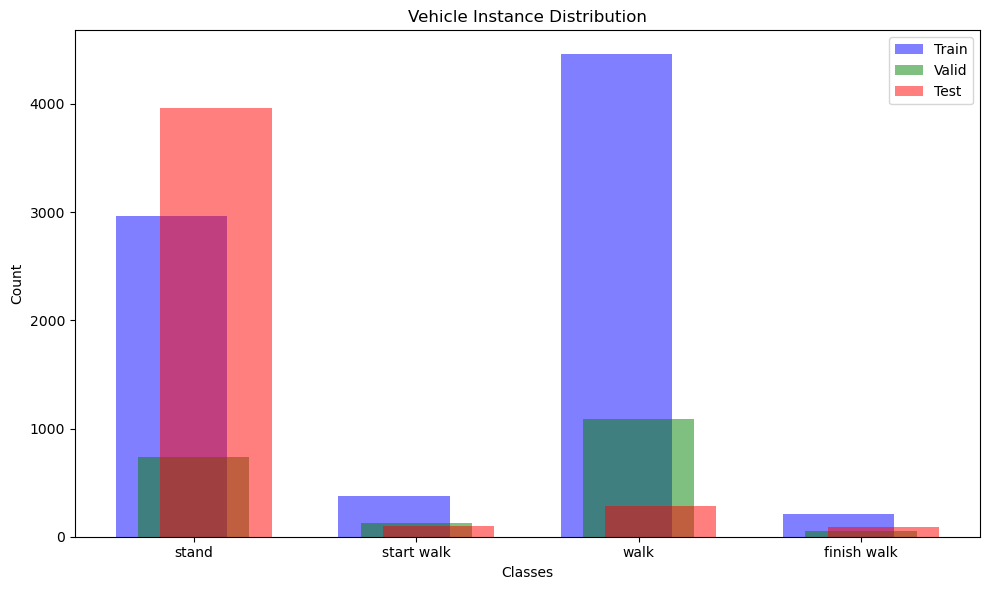

In [11]:
x = np.arange(len(classes))

# 막대 너비
bar_width = 0.5

# 플롯 생성
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width * 0.2, train_dataset_list, width=bar_width, color='blue', alpha=0.5, label='Train')
plt.bar(x, val_dataset_list, width=bar_width, color='green', alpha=0.5, label='Valid')
plt.bar(x + bar_width * 0.2, test_dataset_list, width=bar_width, color='red', alpha=0.5, label='Test')

# x축과 y축 설정
plt.xticks(x, classes)
plt.ylabel('Count')
plt.xlabel('Classes')
plt.title('Vehicle Instance Distribution')
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()

In [12]:
frames, test_names = get_total_frames('/workspace/raw_data/')

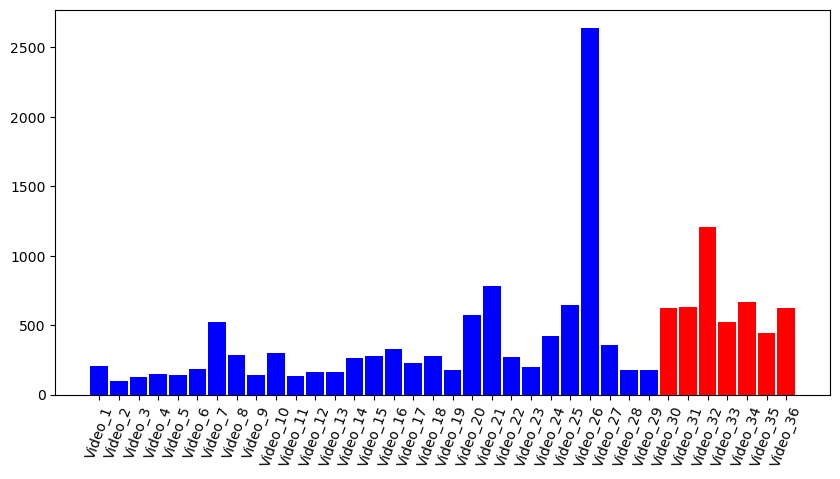

In [13]:
num_video = len(frames)
x = np.arange(num_video)

video_names = ['Video_'+str(x+1) for x in range(num_video)]
video_frames = [frames[x][0] for x in video_names]
video_fps = [frames[x][1] for x in video_names]
colors = ['red' if k in test_names else 'blue' for k in video_names]

plt.figure(figsize=(10, 5))
plt.bar(x, video_frames, color=colors, width=0.9)
plt.xticks(x, video_names, rotation=70)

plt.show()

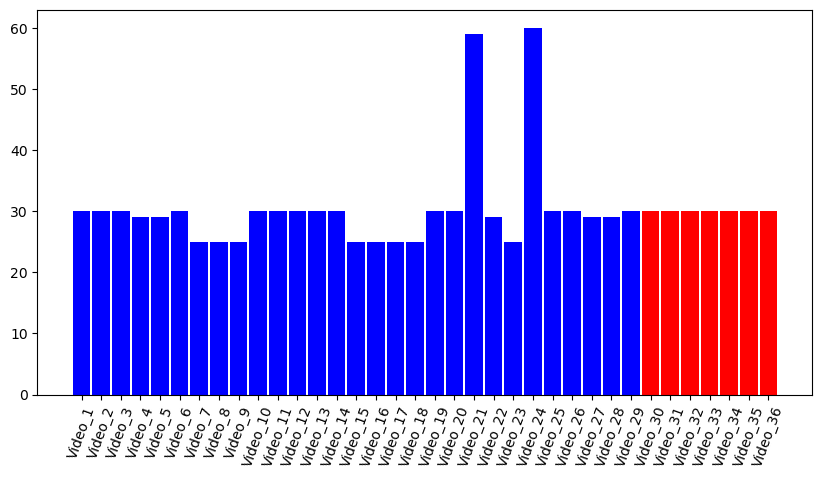

In [14]:
plt.figure(figsize=(10, 5))
plt.bar(x, video_fps, color=colors, width=0.9)
plt.xticks(x, video_names, rotation=70)

plt.show()

In [239]:
video_frames

[203,
 98,
 128,
 146,
 144,
 181,
 525,
 288,
 139,
 300,
 134,
 163,
 159,
 260,
 275,
 325,
 225,
 275,
 180,
 570,
 780,
 270,
 200,
 420,
 645,
 2641,
 359,
 174,
 175,
 625,
 631,
 1208,
 523,
 665,
 444,
 625]

In [237]:
frames

{'Video_29': (175, 30),
 'Video_11': (134, 30),
 'Video_22': (270, 29),
 'Video_17': (225, 25),
 'Video_19': (180, 30),
 'Video_2': (98, 30),
 'Video_5': (144, 29),
 'Video_26': (2641, 30),
 'Video_1': (203, 30),
 'Video_13': (159, 30),
 'Video_20': (570, 30),
 'Video_28': (174, 29),
 'Video_4': (146, 29),
 'Video_25': (645, 30),
 'Video_7': (525, 25),
 'Video_6': (181, 30),
 'Video_12': (163, 30),
 'Video_15': (275, 25),
 'Video_16': (325, 25),
 'Video_27': (359, 29),
 'Video_14': (260, 30),
 'Video_23': (200, 25),
 'Video_24': (420, 60),
 'Video_18': (275, 25),
 'Video_21': (780, 59),
 'Video_9': (139, 25),
 'Video_10': (300, 30),
 'Video_8': (288, 25),
 'Video_3': (128, 30),
 'Video_31': (631, 30),
 'Video_35': (444, 30),
 'Video_30': (625, 30),
 'Video_33': (523, 30),
 'Video_32': (1208, 30),
 'Video_34': (665, 30),
 'Video_36': (625, 30)}

In [234]:
'video_'+str(10)

'video_10'

In [160]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [161]:
class Deep_LSTM(nn.Module):
    def __init__(self):
        super(Deep_LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=69, hidden_size=128, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, num_layers=1, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=256, hidden_size=512, num_layers=1, batch_first=True)
        self.dropout1 = nn.Dropout(0.3)
        self.lstm4 = nn.LSTM(input_size=512, hidden_size=256, num_layers=1, batch_first=True)
        self.lstm5 = nn.LSTM(input_size=256, hidden_size=128, num_layers=1, batch_first=True)
        self.lstm6 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
        self.dropout2 = nn.Dropout(0.3)
        self.lstm7 = nn.LSTM(input_size=64, hidden_size=32, num_layers=1, batch_first=True)
        self.fc = nn.Linear(32,4)

    def forward(self, x) :
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.dropout1(x)
        x, _ = self.lstm4(x)
        x, _ = self.lstm5(x)
        x, _ = self.lstm6(x)
        x = self.dropout2(x)
        x, _ = self.lstm7(x)
        x = self.fc(x[:,-1,:])
        return x

In [162]:
def init_model():
    plt.rc('font', size = 10)
    global net, loss_fn, optim
    net = Deep_LSTM().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=0.0001)

def init_epoch():
    global epoch_cnt
    epoch_cnt = 0

def init_log():
    plt.rc('font', size = 10)
    # 모든 Log를 초기화
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []

In [163]:
def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()

# 학습 알고리즘
def epoch(data_loader, mode = 'train'):
    global epoch_cnt
    
    # 사용되는 변수 초기화
    iter_loss, iter_acc, last_grad_performed = [], [], False
    
    # 1 iteration 학습 알고리즘(for문을 나오면 1 epoch 완료)
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.type(torch.LongTensor).to(device)

        # 1. Feed-forward
        if mode == 'train':
            net.train()
        else:
            # 학습때만 쓰이는 Dropout, Batch Mormalization을 미사용
            net.eval()

        result = net(data) # 1 Batch에 대한 결과가 모든 Class에 대한 확률값으로
        _, out = torch.max(result, 1) # result에서 최대 확률값을 기준으로 예측 class 도출
        
        # 2. Loss 계산
        loss = loss_fn(result, label) # GT 와 Label 비교하여 Loss 산정
        iter_loss.append(loss.item()) # 학습 추이를 위하여 Loss를 기록
        
        # 3. 역전파 학습 후 Gradient Descent
        if mode == 'train':
            optim.zero_grad() # 미분을 통해 얻은 기울기르 초기화 for 다음 epoch
            loss.backward() # 역전파 학습
            optim.step() # Gradient Descent 수행
            last_grad_performed = True # for문 나가면 epoch 카운터 += 1
            
        # 4. 정확도 계산
        acc_partial = (out == label).float().sum() # GT == Label 인 개수
        acc_partial = acc_partial / len(label) # ( TP / (TP + TN)) 해서 정확도 산출
        iter_acc.append(acc_partial.item()) # 학습 추이를 위하여 Acc. 기록
        
    # 역전파 학습 후 Epoch 카운터 += 1
    if last_grad_performed:
        epoch_cnt += 1
    
    clear_memory()
    
    # loss와 acc의 평균값 for 학습추이 그래프, 모든 GT와 Label값 for 컨퓨전 매트릭스
    return np.average(iter_loss), np.average(iter_acc)

def epoch_not_finished():
    # 에폭이 끝남을 알림
    return epoch_cnt < maximum_epoch

In [164]:
def record_train_log(_tloss, _tacc, _time):
    # Train Log 기록용
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)
    
def record_valid_log(_vloss, _vacc):
    # Validation Log 기록용
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    # 리스트 안의 마지막 숫자를 반환(print_log 함수에서 사용)
    if len(log_list) > 0:
        return log_list[len(log_list) - 1]
    else:
        return -1

def print_log():
    # 학습 추이 출력
    
    # 소숫점 3자리 수까지 조절
    train_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 3)
    
    log_str = 'Epoch: {:3} | T_Loss {:5} | T_acc {:5} | V_Loss {:5} | V_acc. {:5} | \
🕒 {:5}'.format(last(iter_log), train_loss, train_acc, val_loss, val_acc, time_spent)
    
    log_stack.append(log_str) # 프린트 준비
    
    # 그래프 출력
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=99) # 1행 2열 서브플롯
    fig.patch.set_facecolor('white')  # 배경색 설정
    
    # Loss 그래프
    axes[0].plot(iter_log, tloss_log, label='Train Loss', color='red', marker='o')
    axes[0].plot(iter_log, vloss_log, label='Valid Loss', color='blue', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss History')
    axes[0].legend()
    axes[0].grid()
    
    # Accuracy 그래프
    axes[1].plot(iter_log, tacc_log, label='Train Acc.', color='red', marker='+')
    axes[1].plot(iter_log, vacc_log, label='Valid Acc.', color='blue', marker='x')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy History')
    axes[1].legend()
    axes[1].grid()
    
    # 그래프 출력
    clear_output(wait=True)
    plt.show()
    
    # 텍스트 로그 출력
    for idx in reversed(range(len(log_stack))): # 반대로 sort 시켜서 출력
        print(log_stack[idx])

In [165]:
init_model()
init_epoch()
init_log()
maximum_epoch = 200

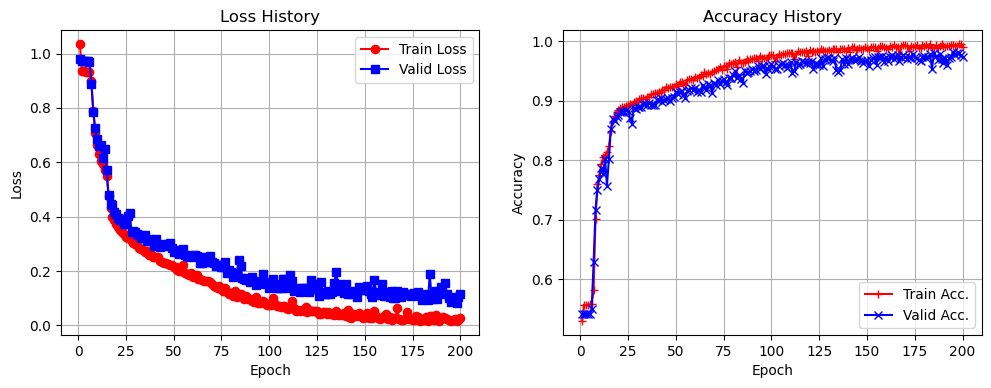

Epoch: 200 | T_Loss 0.027 | T_acc 0.991 | V_Loss 0.114 | V_acc. 0.973 | 🕒 3.948
Epoch: 199 | T_Loss 0.021 | T_acc 0.995 | V_Loss 0.103 | V_acc. 0.977 | 🕒 3.546
Epoch: 198 | T_Loss 0.015 | T_acc 0.995 | V_Loss 0.082 | V_acc. 0.981 | 🕒 5.775
Epoch: 197 | T_Loss 0.023 | T_acc 0.992 | V_Loss  0.09 | V_acc.  0.98 | 🕒 3.531
Epoch: 196 | T_Loss 0.021 | T_acc 0.992 | V_Loss 0.104 | V_acc. 0.977 | 🕒 3.946
Epoch: 195 | T_Loss 0.016 | T_acc 0.994 | V_Loss 0.086 | V_acc. 0.982 | 🕒 3.795
Epoch: 194 | T_Loss  0.02 | T_acc 0.994 | V_Loss 0.099 | V_acc. 0.974 | 🕒  3.85
Epoch: 193 | T_Loss 0.024 | T_acc 0.992 | V_Loss 0.114 | V_acc. 0.971 | 🕒   4.3
Epoch: 192 | T_Loss 0.026 | T_acc 0.991 | V_Loss 0.156 | V_acc.  0.96 | 🕒 3.336
Epoch: 191 | T_Loss  0.03 | T_acc  0.99 | V_Loss 0.114 | V_acc. 0.972 | 🕒 3.738
Epoch: 190 | T_Loss 0.021 | T_acc 0.992 | V_Loss  0.14 | V_acc. 0.964 | 🕒 5.242
Epoch: 189 | T_Loss 0.017 | T_acc 0.995 | V_Loss 0.125 | V_acc.  0.97 | 🕒 3.549
Epoch: 188 | T_Loss 0.023 | T_acc 0.992 

In [166]:
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader, mode = 'train')
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(val_loader, mode = 'val')
        record_valid_log(vloss, vacc)
    print_log()

print('\n Training completed!')

In [168]:
with torch.no_grad():
    test_loss, test_acc = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))

Test Acc.: 0.4206
Test Loss: 4.8984


In [169]:
torch.save(net.state_dict(), 'model_02.pth')

In [170]:
EPOCH = 195
PATH = "model_02.pt"
LOSS = 0.016
optimizer = optim

torch.save({
            'epoch': EPOCH,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [171]:
delete_cash(device)

memory allocated : 67387392
memory reserved : 81788928
